In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re, emoji, itertools
from sklearn.model_selection import train_test_split 
import torch

In [8]:
TRAIN_DATA_PATH = r"..\data\train.csv"
TEST_DATA_PATH = r"..\data\test.csv"

In [9]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

# EDA

In [10]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


c:\Users\Admin\Envs\tweetenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Target counts for train set')]

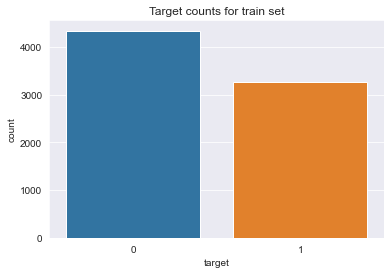

In [11]:
sns.set_style("darkgrid")
sns.countplot(df_train.target).set(title='Target counts for train set')

In [12]:
from sklearn import naive_bayes, svm
svm.SVC()

SVC()

# Preprocessing

In [13]:
#tkis should be loaded from e.g text file
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [14]:
def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text


In [15]:
df_train['text']=df_train['text'].apply(remove_contractions)
df_test['text']=df_test['text'].apply(remove_contractions)

In [16]:
def clean_dataset(text):
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 4 or fewer letters
    text = re.sub(r'\b\w{1,4}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [17]:
df_train['text'] =df_train['text'].apply(clean_dataset)
df_test['text'] =df_test['text'].apply(clean_dataset)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake ALLAH Forgive,1
1,4,NaN,NaN,Forest Ronge Canada,1
2,5,NaN,NaN,residents asked shelter place being notified o...,1
3,6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
4,7,NaN,NaN,photo Alaska smoke wildfires pours school,1


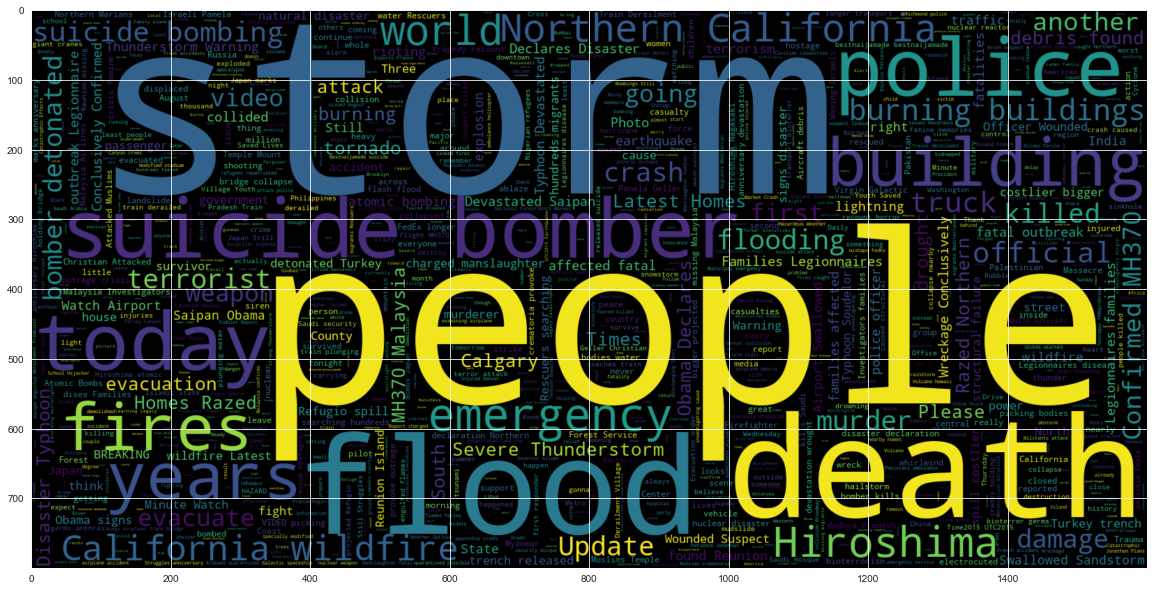

In [18]:
#plot for real disaster tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_train[df_train.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

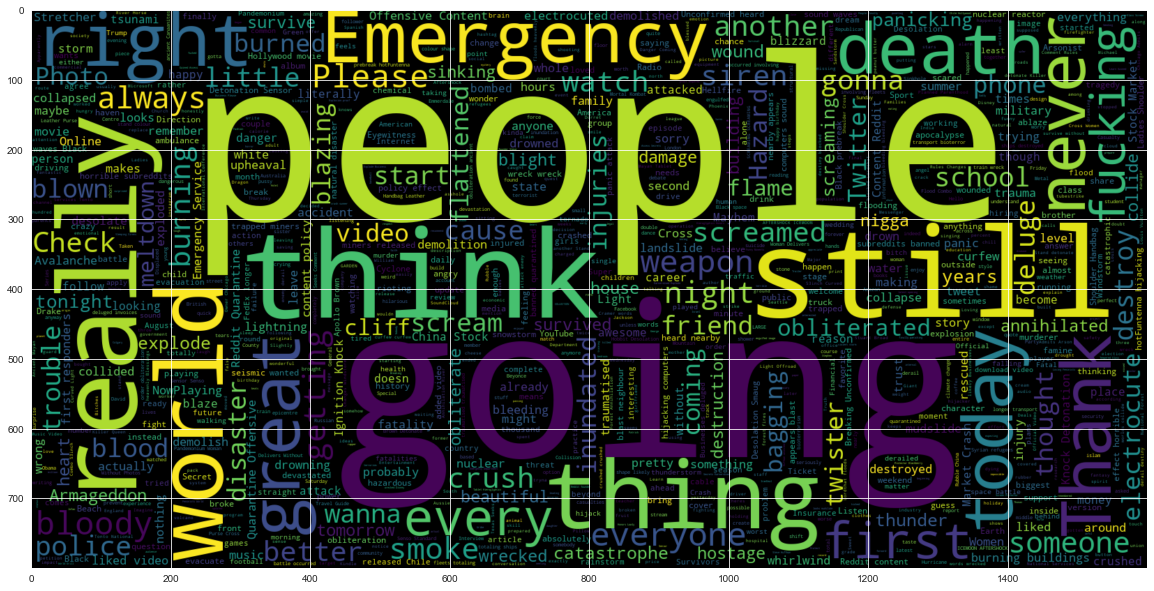

In [19]:
#plot for fake disaster tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_train[df_train.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [20]:
df_train.drop(["keyword","location"], axis = 1, inplace = True)
df_test.drop(["keyword","location"], axis = 1, inplace = True)

In [21]:
X_train_clean, X_eval_clean, y_train_clean, y_eval_clean = train_test_split(df_train['text'], df_train['target'], test_size=.15, random_state=42)

In [22]:
df_train_clean = pd.concat([X_train_clean, y_train_clean], axis=1)
df_eval_clean = pd.concat([X_eval_clean, y_eval_clean], axis=1)


In [23]:
from datasets import Dataset

In [24]:
df_train_clean = Dataset.from_pandas(df_train_clean)
df_eval_clean = Dataset.from_pandas(df_eval_clean)
df_test_clean = Dataset.from_pandas(df_test)

In [25]:
df_train_clean

Dataset({
    features: ['text', 'target', '__index_level_0__'],
    num_rows: 6471
})

In [26]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [27]:
text  = "Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters"

In [28]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [0, 15852, 10, 739, 32644, 16, 10, 936, 142, 24, 3441, 26739, 4836, 7, 33, 41, 7934, 346, 9, 17294, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [29]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', 'Having', 'Ġa', 'Ġlarge', 'Ġvocabulary', 'Ġis', 'Ġa', 'Ġproblem', 'Ġbecause', 'Ġit', 'Ġrequires', 'Ġneural', 'Ġnetworks', 'Ġto', 'Ġhave', 'Ġan', 'Ġenormous', 'Ġnumber', 'Ġof', 'Ġparameters', '</s>']


In [30]:
print(tokenizer.convert_tokens_to_string(tokens))

<s>Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters</s>


In [31]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [32]:
train_encoded = df_train_clean.map(tokenize, batched=True, batch_size=None)
eval_encoded = df_eval_clean.map(tokenize, batched=True, batch_size=None)
test_encoded = df_test_clean.map(tokenize, batched=True, batch_size=None)

Parameter 'function'=<function tokenize at 0x00000266E26F3D30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
train_encoded

Dataset({
    features: ['text', 'target', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 6471
})

In [34]:
train_encoded = train_encoded.remove_columns('__index_level_0__')
eval_encoded = eval_encoded.remove_columns('__index_level_0__')
# test_encoded = test_encoded.remove_columns('__index_level_0__')

In [35]:
train_encoded = train_encoded.rename_column("target", "label")

eval_encoded = eval_encoded.rename_column("target", "label")
# test_encoded = test_encoded.rename_column("target", "label")

In [36]:
train_encoded

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6471
})

In [37]:
from transformers import AutoModel
model_ckpt = "roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AutoModel.from_pretrained(model_ckpt).to(device)

In [38]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [39]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [40]:
from transformers import Trainer, TrainingArguments

In [41]:
batch_size = 16
logging_steps = len(train_encoded) // batch_size
model_name = f"{model_ckpt}-disaster-tweets"
training_args = TrainingArguments(output_dir=model_name,
num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=logging_steps,
push_to_hub=True,
log_level="error")

In [42]:
torch.cuda.empty_cache()

In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [44]:
train_encoded

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6471
})

In [45]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=train_encoded,
eval_dataset=eval_encoded,
tokenizer=tokenizer)
trainer.train()

Cloning https://huggingface.co/PanNorek/roberta-base-disaster-tweets into local empty directory.
c:\Users\Admin\Envs\tweetenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def test_fun(text:str):
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    inputs = {k:v.to(device) for k,v in input_ids.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs["logits"].argmax()

In [ ]:
from scipy.special import softmax

In [ ]:
results = []
for x in df_test["text"]:
    # input_ids = torch.tensor(tokenizer.encode(x, add_special_tokens=True)).unsqueeze(0)
    inputs = tokenizer(x, return_tensors="pt")
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    
    probabilities = softmax(outputs["logits"].cpu().numpy(), axis=1)
    # print(probabilities)
    results.append(probabilities.argmax())
    

In [ ]:
results = pd.DataFrame(results)
results.size

3263

In [ ]:
df_test

,id,text
0,0,happened terrible crash
1,2,Heard about earthquake different cities everyone
2,3,there forest geese fleeing across street cannot
3,9,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills China Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY ANGELES SAFETY FASTENERS
3259,10865,Storm worse hurricane city3others hardest look...
3260,10868,Green derailment Chicago
3261,10874,issues Hazardous Weather Outlook


In [ ]:
tmp = pd.concat([df_test,results],axis = 1 )

In [ ]:
tmp = tmp.drop("text",axis = 1)

In [ ]:
tmp.columns = ['id', "target"]

In [ ]:
tmp.to_csv("submission2.csv",index = False)

# solution 2

In [ ]:
from transformers import AutoModel
model_ckpt = "distilroberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=train_encoded,
eval_dataset=eval_encoded,
tokenizer=tokenizer)
trainer.train()

Cloning https://huggingface.co/PanNorek/distilroberta-base-disaster-tweets into local empty directory.
c:\Users\Admin\Envs\tweetenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/810 [00:00<?, ?it/s]

{'loss': 0.488, 'learning_rate': 1.0024691358024692e-05, 'epoch': 1.0}


  0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4723990261554718, 'eval_accuracy': 0.8064798598949212, 'eval_f1': 0.8035498456409427, 'eval_runtime': 1.9877, 'eval_samples_per_second': 574.546, 'eval_steps_per_second': 36.224, 'epoch': 1.0}
{'loss': 0.3866, 'learning_rate': 4.938271604938272e-08, 'epoch': 2.0}


  0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4736548960208893, 'eval_accuracy': 0.8047285464098074, 'eval_f1': 0.8029773323999172, 'eval_runtime': 2.0348, 'eval_samples_per_second': 561.23, 'eval_steps_per_second': 35.384, 'epoch': 2.0}
{'train_runtime': 140.9664, 'train_samples_per_second': 91.809, 'train_steps_per_second': 5.746, 'train_loss': 0.4376082075966729, 'epoch': 2.0}


TrainOutput(global_step=810, training_loss=0.4376082075966729, metrics={'train_runtime': 140.9664, 'train_samples_per_second': 91.809, 'train_steps_per_second': 5.746, 'train_loss': 0.4376082075966729, 'epoch': 2.0})

In [ ]:
results = []
for x in df_test["text"]:
    # input_ids = torch.tensor(tokenizer.encode(x, add_special_tokens=True)).unsqueeze(0)
    inputs = tokenizer(x, return_tensors="pt")
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    
    probabilities = softmax(outputs["logits"].cpu().numpy(), axis=1)
    # print(probabilities)
    results.append(probabilities.argmax())